In [2]:
import warnings
!pip install keras-preprocessing
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob
import cv2
import imutils
import seaborn as sns
from sklearn.utils import shuffle
from keras_preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from keras.models import Model, Sequential
import keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.6 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Data Loading**

In [5]:
#Unzip data
!unzip '/content/archive.zip'

unzip:  cannot find or open /content/archive.zip, /content/archive.zip.zip or /content/archive.zip.ZIP.


In [9]:
#Count images in the two folders: yes (Tumor) and no (Healthey)
root =  '/content/drive/MyDrive/brain_tumor_dataset'
dict_img = {}
for dir in os.listdir(root):
  dict_img[dir] = len(os.listdir(os.path.join(root, dir)))
dict_img

{'no': 98, 'yes': 155}

So we have 155 Brain MRI images with a tumor and 98 healthey ones.

Files in 'yes' directory: ['Y162.jpg', 'Y160.JPG', 'Y163.JPG', 'Y161.JPG', 'Y10.jpg', 'Y1.jpg', 'Y169.jpg', 'Y170.JPG', 'Y18.JPG', 'Y105.jpg', 'Y107.jpg', 'Y104.jpg', 'Y12.jpg', 'Y14.jpg', 'Y146.JPG', 'Y147.JPG', 'Y15.jpg', 'Y120.JPG', 'Y154.jpg', 'Y166.JPG', 'Y13.jpg', 'Y182.JPG', 'Y181.jpg', 'Y148.JPG', 'Y153.jpg', 'Y183.jpg', 'Y180.jpg', 'Y115.JPG', 'Y113.JPG', 'Y114.JPG', 'Y116.JPG', 'Y17.jpg', 'Y167.JPG', 'Y168.jpg', 'Y165.JPG', 'Y164.JPG', 'Y155.JPG', 'Y159.JPG', 'Y16.JPG', 'Y158.JPG', 'Y157.JPG', 'Y156.JPG', 'Y108.jpg', 'Y117.JPG', 'Y11.jpg', 'Y109.JPG', 'Y111.JPG', 'Y112.JPG', 'Y101.jpg', 'Y106.jpg', 'Y103.jpg', 'Y100.JPG', 'Y102.jpg', 'Y245.jpg', 'Y242.JPG', 'Y24.jpg', 'Y23.JPG', 'Y20.jpg', 'Y21.jpg', 'Y22.jpg', 'Y2.jpg', 'Y195.JPG', 'Y193.JPG', 'Y194.jpg', 'Y192.JPG', 'Y19.JPG', 'Y186.jpg', 'Y187.jpg', 'Y188.jpg', 'Y185.jpg', 'Y184.JPG', 'Y92.png', 'Y91.jpg', 'Y92.jpg', 'Y90.jpg', 'Y9.jpg', 'Y89.JPG', 'Y81.jpg', 'Y85.JPG', 'Y82.jpg', 'Y86.JPG', 'Y257.jpg', 'Y253.JPG', 'Y252.j

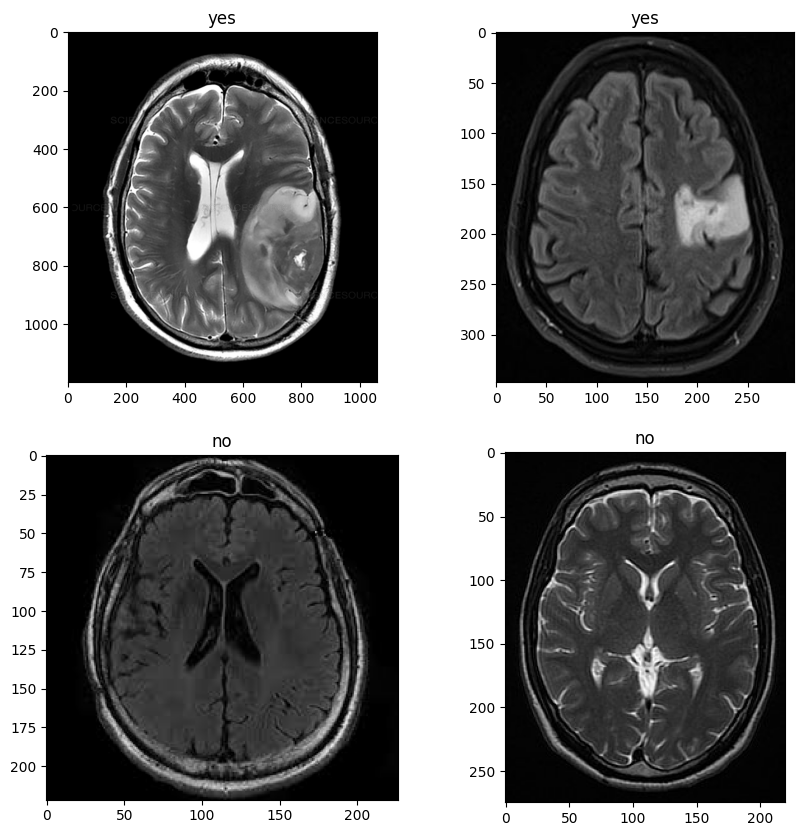

In [15]:
import os
import matplotlib.pyplot as plt
from keras_preprocessing.image import load_img

# Define the root directory path to the 'yes' and 'no' directories
root_dir_yes = '/content/drive/MyDrive/brain_tumor_dataset/yes'
root_dir_no = '/content/drive/MyDrive/brain_tumor_dataset/no'

# Check if the directories exist and print out their contents
print("Files in 'yes' directory:", os.listdir(root_dir_yes))
print("Files in 'no' directory:", os.listdir(root_dir_no))

# Create a figure for displaying images
plt.figure(figsize=(10, 10))

# Subplot 1: First image from the 'yes' folder
image_path_1 = os.path.join(root_dir_yes, os.listdir(root_dir_yes)[0])
plt.subplot(2, 2, 1)
plt.imshow(load_img(image_path_1))
plt.title('yes')

# Subplot 2: Second image from the 'yes' folder
image_path_2 = os.path.join(root_dir_yes, os.listdir(root_dir_yes)[1])
plt.subplot(2, 2, 2)
plt.imshow(load_img(image_path_2))
plt.title('yes')

# Subplot 3: First image from the 'no' folder
image_path_3 = os.path.join(root_dir_no, os.listdir(root_dir_no)[0])
plt.subplot(2, 2, 3)
plt.imshow(load_img(image_path_3))
plt.title('no')

# Subplot 4: Second image from the 'no' folder
image_path_4 = os.path.join(root_dir_no, os.listdir(root_dir_no)[1])
plt.subplot(2, 2, 4)
plt.imshow(load_img(image_path_4))
plt.title('no')

# Display the plot
plt.show()


## **Image Augmentation**

As much as our training set contains more data, the model's accuracy will improve. Data augmentation is a technique used to increase the amount of data by adding slightly modified copies of already existing data.

In [17]:
#Define a function for image augmentation
def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.1,
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest',
                                  rescale= 1/255
                                 )

    for filename in os.listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
                i += 1
                if i > n_generated_samples:
                    break

In [18]:
#Create augmented images folders
#L = ['aug_train', 'aug_test', 'aug_val']
name = 'aug_data'
if not os.path.exists("./"+name):
  os.mkdir("./"+name)
  for dir in os.listdir(root):
    os.makedirs("./"+name+"/"+dir)
else:
  print(f"{name} Already exists")

In [22]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Define the directories for the 'yes' and 'no' folders
yes_dir = './brain_tumor_dataset/yes'  # Update this path if necessary
no_dir = './brain_tumor_dataset/no'    # Update this path if necessary

# Check if directories exist
if not os.path.exists(yes_dir):
    print(f"The directory {yes_dir} does not exist.")
else:
    print(f"The directory {yes_dir} exists.")

if not os.path.exists(no_dir):
    print(f"The directory {no_dir} does not exist.")
else:
    print(f"The directory {no_dir} exists.")

# If both directories exist, continue with data augmentation
if os.path.exists(yes_dir) and os.path.exists(no_dir):
    def augment_data(file_dir, n_generated_samples, save_to_dir):
        # Create a data generator with various augmentations
        datagen = ImageDataGenerator(
            rotation_range=40,      # Randomly rotate images
            width_shift_range=0.2,  # Randomly shift horizontally
            height_shift_range=0.2, # Randomly shift vertically
            shear_range=0.2,        # Shear angle
            zoom_range=0.2,         # Random zoom
            horizontal_flip=True,   # Randomly flip images
            fill_mode='nearest'     # Fill missing pixels after transformations
        )

        # Check if the save directory exists, if not, create it
        if not os.path.exists(save_to_dir):
            os.makedirs(save_to_dir)

        # Get all image files from the directory
        image_files = os.listdir(file_dir)
        count = 0

        for image_name in image_files:
            image_path = os.path.join(file_dir, image_name)

            # Load and convert image to array
            img = load_img(image_path)
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)  # Reshaping for the ImageDataGenerator

            # Generate augmented images and save them
            i = 0
            for batch in datagen.flow(x, batch_size=1, save_to_dir=save_to_dir, save_prefix='aug', save_format='jpeg'):
                i += 1
                count += 1
                if i >= n_generated_samples:  # Stop after generating 'n_generated_samples' for this image
                    break

        print(f"Generated {count} augmented images in {save_to_dir}.")

    # Augment data for the 'yes' label (18 new samples)
    augment_data(file_dir=yes_dir, n_generated_samples=18, save_to_dir='./aug_data/yes')

    # Augment data for the 'no' label (22 new samples)
    augment_data(file_dir=no_dir, n_generated_samples=22, save_to_dir='./aug_data/no')


The directory ./brain_tumor_dataset/yes does not exist.
The directory ./brain_tumor_dataset/no does not exist.


## **Split data into train, validation and test sets**

In [23]:
#Count images in the two folders: yes (Tumor) and no (Healthey) in the folder of augmented images
root =  '/content/aug_data'
dict_img = {}
for dir in os.listdir(root):
  dict_img[dir] = len(os.listdir(os.path.join(root, dir)))
dict_img

{'yes': 0, 'no': 0}

In [24]:
#Define a function that creates new folders for the train, test and val sets and append random pictures to them based on the split percentage
def create_folders(name, perc):
  if not os.path.exists("./"+name):
    os.mkdir("./"+name)
    for dir in os.listdir(root):
      os.makedirs("./"+name+"/"+dir)
      for img in np.random.choice(a=os.listdir(os.path.join(root, dir)), size=(math.floor(perc*dict_img[dir])), replace=False):
        Src = os.path.join(root, dir, img)
        Dest = os.path.join("./"+name, dir)
        shutil.copy(Src, Dest)
        os.remove(Src)
  else:
    print(f"{name} Already exists")

In [25]:
#Create the training set
create_folders('train', 0.7)

In [26]:
#Create the test set
create_folders('test', 0.15)

In [27]:
#Create the validation set
create_folders('val', 0.15)

In [28]:
#Define a function that counts images in the folders: yes (Tumor) and no (Healthey)
def count_img(folder):
  dict_img = {}
  for dir in os.listdir(folder):
    dict_img[dir] = len(os.listdir(os.path.join(folder, dir)))
  return dict_img

In [29]:
#Count images in the training set
count_img('train')

{'yes': 0, 'no': 0}

In [30]:
#Count images in the test set
count_img('test')

{'yes': 0, 'no': 0}

In [31]:
#Count images in the validation set
count_img('val')

{'yes': 0, 'no': 0}

## **Image Preprocessing**

In [32]:
#Define a function that crop tha brain contour
def crop_brain_contour(image, plot=False):

    #Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    #Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    #Extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    #Crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()

    return new_image

In [33]:
#Example
ex_img = cv2.imread('no/1 no.jpeg')
img = crop_brain_contour(ex_img, plot=True)

error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
#Define a function that load data
def load_data(dir_list, image_size):

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size

    for directory in dir_list:
        for filename in os.listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])

    X = np.array(X)
    y = np.array(y)

    # Shuffle the data







    X, y = shuffle(X, y)

    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')

    return X, y

In [ ]:
#Load trainig data
IMG_WIDTH, IMG_HEIGHT = (240, 240)
X_train, y_train = load_data(['/content/train/yes', '/content/train/no'], (IMG_WIDTH, IMG_HEIGHT))

In [ ]:
#Define a function that plot images
def plot_sample_images(X, y, n=40):
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(10, 8))

        i = 1 # current plot
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            # remove ticks
            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)

            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

In [ ]:
#Plot samples from the training set
plot_sample_images(X_train, y_train)

We can notice that the noise has been deleted and some images look alike with some slight changes resulted from the data augmentation

In [ ]:
#Load test data
IMG_WIDTH, IMG_HEIGHT = (240, 240)
X_test, y_test = load_data(['/content/test/yes', '/content/test/no'], (IMG_WIDTH, IMG_HEIGHT))

In [ ]:
#Load validation data
IMG_WIDTH, IMG_HEIGHT = (240, 240)
X_val, y_val = load_data(['/content/val/yes', '/content/val/no'], (IMG_WIDTH, IMG_HEIGHT))

In [ ]:
#Plot samples from the validation set
plot_sample_images(X_val, y_val)

## **CNN Model**

In [ ]:
#Build our model
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', input_shape = (240, 240, 3)))

model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Dropout(rate = 0.25))

model.add(Flatten())
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dropout(rate = 0.25))
model.add(Dense(units = 1, activation = 'sigmoid'))

model.summary()

In [ ]:
#Compile our model
model.compile(optimizer = 'adam', loss = keras.losses.binary_crossentropy, metrics = ['accuracy'])

In [ ]:
#Early stopping and model checkpoint
from keras.callbacks import ModelCheckpoint, EarlyStopping

es = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.01, patience = 5, verbose = 1, mode = 'auto')
mc = ModelCheckpoint(monitor ='val_accuracy', filepath = './bestmodel.h5', verbose = 1, save_best_only = True, mode = 'auto')

cd = [es, mc]

In [ ]:
#Train our model
hist = model.fit(x = X_train, y = y_train, batch_size = 32, epochs = 30, validation_data = (X_val, y_val), callbacks = cd, verbose = 1)

In [ ]:
#Plot the graphical interpretation
h = hist.history
plt.plot(h['accuracy'], label = 'accuracy')
plt.plot(h['val_accuracy'], label = 'val-accuracy')
plt.title('Accuracy vs Val Accuracy')
plt.legend()
plt.show()

In [ ]:
#Plot the graphical interpretation
h = hist.history
plt.plot(h['loss'], label = 'loss')
plt.plot(h['val_loss'], label = 'val-loss')
plt.title('Loss vs Val Loss')
plt.legend()
plt.show()

In [ ]:
#Test our model on the test set
from keras.models import load_model
model = load_model('/content/bestmodel.h5')
acc = model.evaluate(X_test, y_test)[1]
print(f'The accuracy of our model is {acc}')

We can see that our model works well on the test set, so it's not overfitted

In [ ]:
#Try our model on a random image that it has never seen before
from keras_preprocessing.image import load_img, img_to_array
#Choose a MRI image with tumor
path = "/content/no/10 no.jpg"
img_yes = load_img(path, target_size=(240,240))
img_array_yes = img_to_array(img_yes)/255
img_array_yes = np.expand_dims(img_array_yes, axis=0)
prediction1 = model.predict(img_array_yes)
class1 = np.round(prediction1).astype(int)
if class1 == 0:
  print("The MRI image doesn't have a Tumor")
else:
  print("The MRI image has a tumor")